In [1]:
# following this: https://www.tensorflow.org/text/tutorials/transformer

In [2]:
# Install the nightly version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
# !pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
# !pip install -q tensorflow_datasets
# !pip install -q -U tensorflow-text tensorflow

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

plt.rcParams['font.size'] = '16'
plt.rcParams['figure.figsize'] = [12.0, 8.0]

2022-09-16 21:15:15.675054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 21:15:15.814100: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-16 21:15:15.819067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 21:15:15.819081: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

2022-09-16 21:15:17.565110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-16 21:15:17.565141: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 21:15:17.565172: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linuxxps): /proc/driver/nvidia/version does not exist
2022-09-16 21:15:17.565521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2022-09-16 21:15:17.843664: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

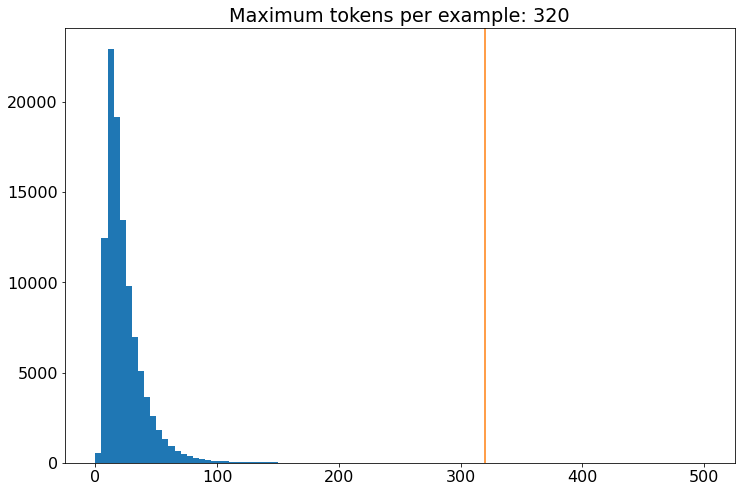

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))


# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [18]:
for (pt, en), en_labels in train_batches.take(1):
  print(pt.shape)
  print(en.shape)

(64, 88)
(64, 92)


In [166]:
def positional_encoding(length, depth, alpha=10000):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (alpha**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  x = np.cos(angle_rads)
  y = np.sin(angle_rads)
  pos_encoding = np.concatenate(
      [x, y],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

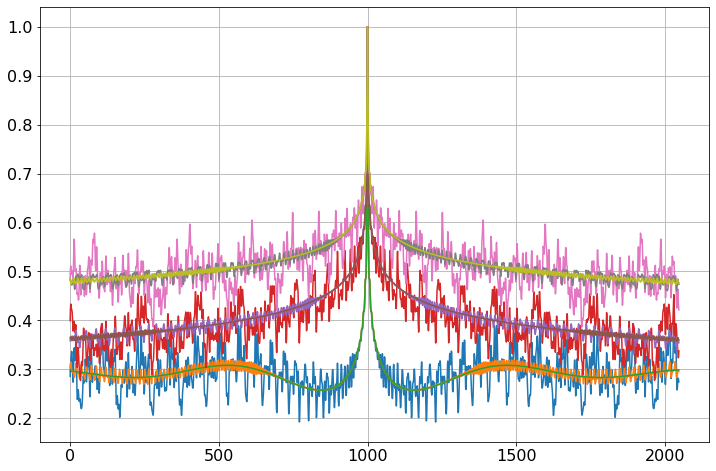

In [171]:
plt.figure()

for alpha in [100,10000, 1000000]:
    for depth in [64, 512 , 2048]:
        for p_i in [1000]:#[10, 1000, 2000]:
        #    depth = 512
            depth2 = depth//2

            pos_encoding = positional_encoding(length=2048, depth=depth, alpha=alpha)
            pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
            x = pos_encoding[:,:depth2]
            y = pos_encoding[:,depth2:]
            z = x.numpy() + 1j * y.numpy()

            p = z[p_i][np.newaxis, :]

            d = np.real(np.sqrt(np.sum((z - p)*np.conj(z-p), axis=1)))

            d = (2 - d)/2.0
            plt.plot(d)
plt.grid()
plt.show()


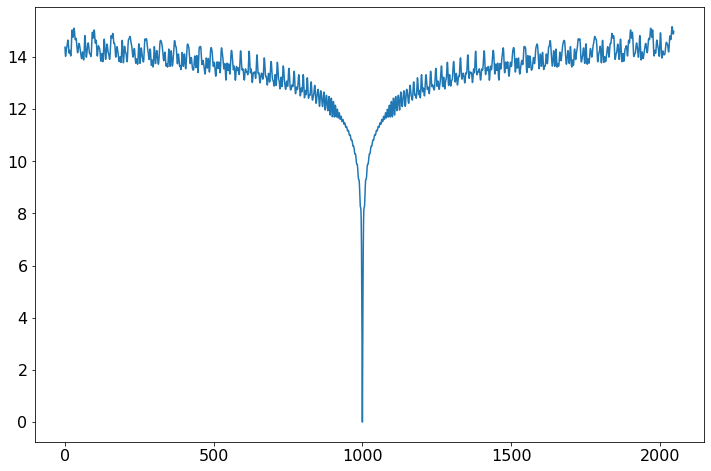

In [144]:
depth = 256
depth2 = depth//2

pos_encoding = positional_encoding(length=2048, depth=depth)
x = pos_encoding[:,:depth2]
y = pos_encoding[:,depth2:]
z = x.numpy() + 1j * y.numpy()

p = z[1000][np.newaxis, :]

d = np.real(np.sqrt(np.sum((z - p)*np.conj(z-p), axis=1)))
plt.figure()
plt.plot(d)
plt.show()

(744.0, 1256.0)

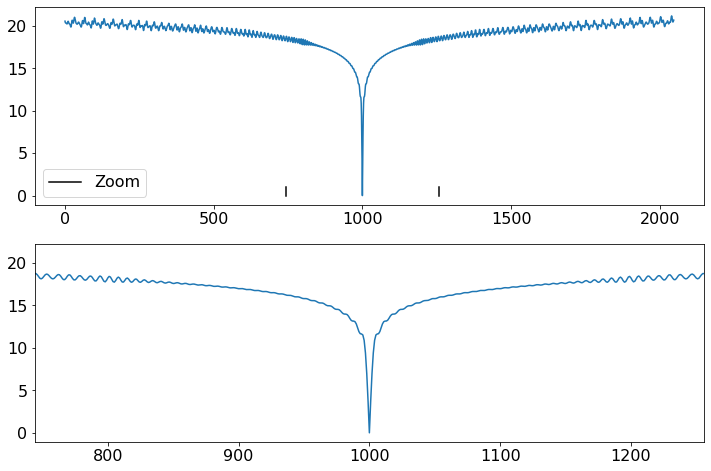

In [142]:
p = z[1000][np.newaxis, :]

d = np.real(np.sqrt(np.sum((z - p)*np.conj(z-p), axis=1)))

plt.subplot(2,1,1)
plt.plot(d)
#plt.ylim([0,1])
plt.plot([1000-256, 1000-256, float('nan'), 1000+256, 1000+256],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(d)
plt.xlim([1000-256, 1000+256])
#plt.ylim([0,1])

In [129]:
p.shape, z.shape

((1, 256), (2048, 256))

In [123]:
dots

array([44.971603-50.67351j , 48.211044-48.832836j, 49.418022-46.578506j,
       ..., 46.618935+38.135994j, 44.55161 +39.2379j  ,
       42.546574+38.201263j], dtype=complex64)

In [119]:
x = pos_encoding[:,:256]
y = pos_encoding[:,256:]
z = x.numpy() + 1j * y.numpy()

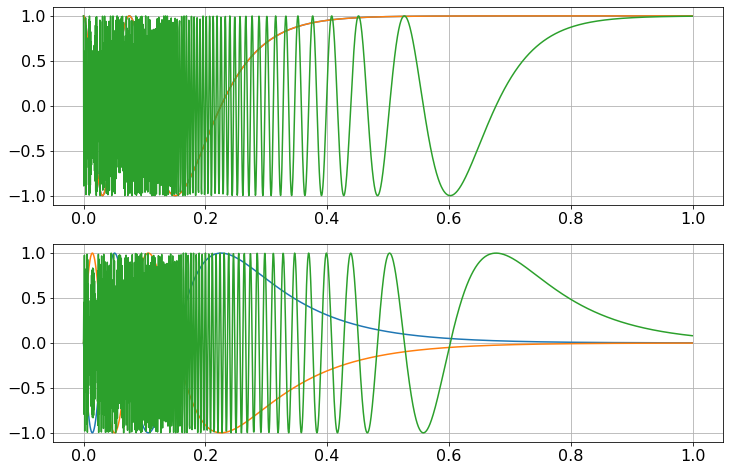

In [113]:
depth = 2048
#length = 10000
positions = 2*np.pi*np.array([2,-2, 128])[:,np.newaxis]
depths = np.arange(depth)[np.newaxis,:]/depth

angle_rates = 1 / (10000**depths)
#angle_rates = depths
angle_rads = positions * angle_rates
x = np.cos(angle_rads).T
y = np.sin(angle_rads).T

d = depths.flatten()
plt.figure()
plt.subplot(2,1,1)
plt.plot(d, x)
plt.grid()
plt.subplot(2,1,2)  
plt.plot(d, y)
plt.grid()
plt.show()

In [109]:
np.log(10000), np.log(10000)/np.log(2), 2**13.2877

(9.210340371976182, 13.287712379549449, 9999.914191870173)

(2048, 512)


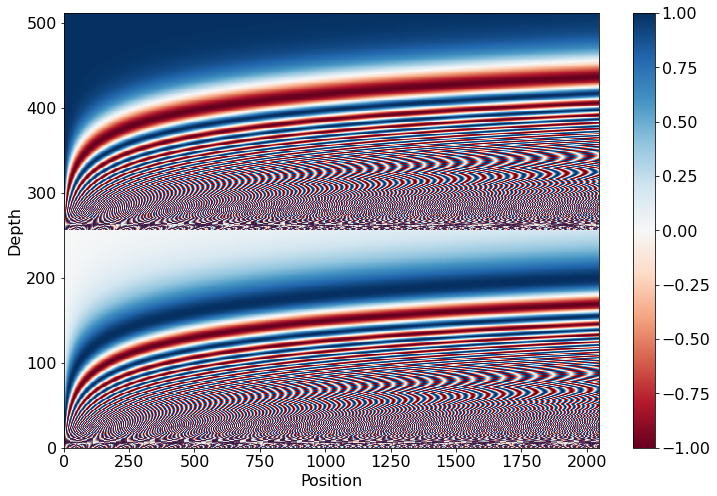

In [33]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()